In [1]:
try:
    import google.colab # type: ignore
    from google.colab import output
    COLAB = True
    %pip install sae-lens transformer-lens
except:
    COLAB = False
    from IPython import get_ipython # type: ignore
    ipython = get_ipython(); assert ipython is not None
    ipython.run_line_magic("load_ext", "autoreload")
    ipython.run_line_magic("autoreload", "2")

In [2]:
# Standard imports
import os
import torch
import numpy as np
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import einops

# import the LLM
from sae_lens import SAE, HookedSAETransformer
from transformers import AutoModelForCausalLM, AutoTokenizer

torch.set_grad_enabled(False)

# For the most part I'll try to import functions and classes near where they are used
# to make it clear where they come from.

if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Device: {device}")

# utility to clear variables out of the memory & and clearing cuda cache
import gc
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

Device: cuda


In [3]:
import os
from dotenv import load_dotenv
from pathlib import Path

if not COLAB:
  # Load environment variables from the .env file
  load_dotenv()

  # Access the PYTHONPATH variable
  pythonpath = Path(os.getenv('PYTHONPATH'))

  # Print to verify
  print(f"PYTHONPATH: {pythonpath}")

  datapath = pythonpath / 'data'
  print(f"Data path: {datapath}")
else:
  datapath = Path('./')
  print(f"Data path: {datapath}")

PYTHONPATH: C:\Edu\Mech_Interp\SAE_merging\SAE-Tuning-Merging
Data path: C:\Edu\Mech_Interp\SAE_merging\SAE-Tuning-Merging\data


In [4]:
# define the model to work with
GEMMA = True

if GEMMA == True:
    RELEASE = 'gemma-2b-res-jb'
    BASE_MODEL = "gemma-2b"
    FINETUNE_MODEL = 'shahdishank/gemma-2b-it-finetune-python-codes'
    FINETUNE_DATASET = 'flytech/python-codes-25k'
    DATASET_NAME = "ctigges/openwebtext-gemma-1024-cl"
    hook_part = 'post'
    layer_num = 6
else:
    RELEASE = 'gpt2-small-res-jb'
    BASE_MODEL = "gpt2-small"
    FINETUNE_MODEL = 'pierreguillou/gpt2-small-portuguese'
    FINETUNE_DATASET = 'legacy-datasets/wikipedia'
    DATASET_NAME = "Skylion007/openwebtext"
    hook_part = 'pre'
    layer_num = 6

In [7]:
base_feature_acts = torch.load(datapath / f'{BASE_MODEL}_base_faof.pt')
finetune_feature_acts = torch.load(datapath / f'{BASE_MODEL}_finetune_faof.pt')

base_feature_acts.shape, finetune_feature_acts.shape

C:\Users\Tarassaco\AppData\Local\Temp\ipykernel_19504\24708525.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  base_feature_acts = torch.load(datapath / f'{BASE_MODEL}_b

(torch.Size([16384]), torch.Size([16384]))

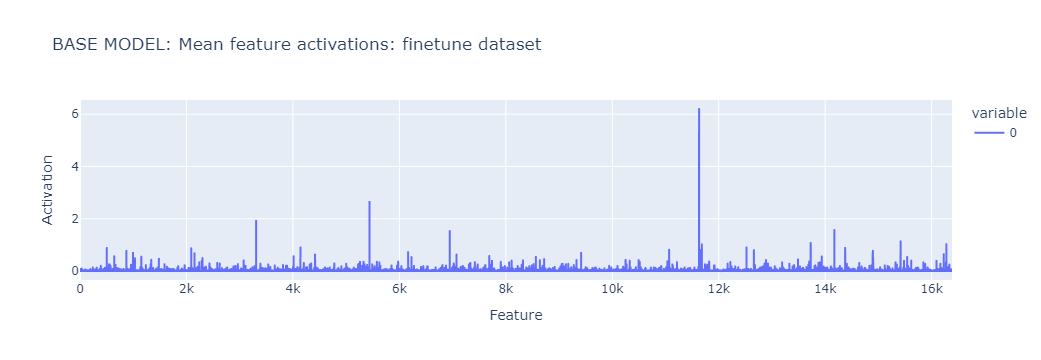

In [11]:
import plotly.express as px

fig = px.line(
    base_feature_acts.cpu(),
    title="BASE MODEL: Mean feature activations: finetune dataset",
    labels={"index": "Feature", "value": "Activation"},
)
fig.show()

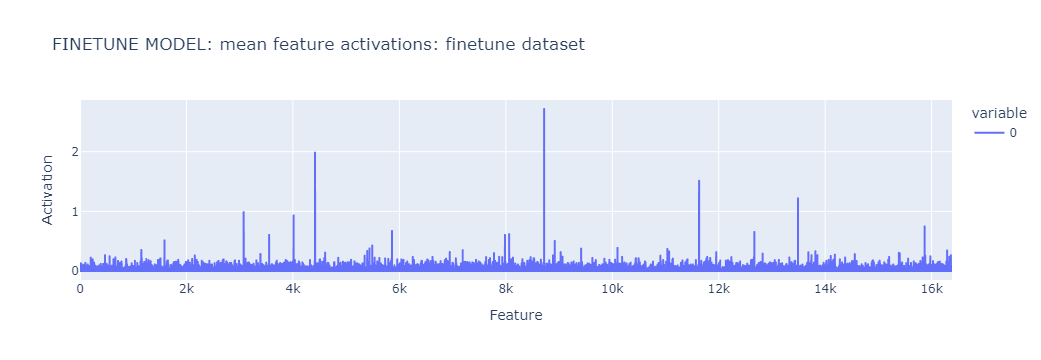

In [12]:
import plotly.express as px

fig = px.line(
    finetune_feature_acts.cpu(),
    title="FINETUNE MODEL: mean feature activations: finetune dataset",
    labels={"index": "Feature", "value": "Activation"},
)
fig.show()

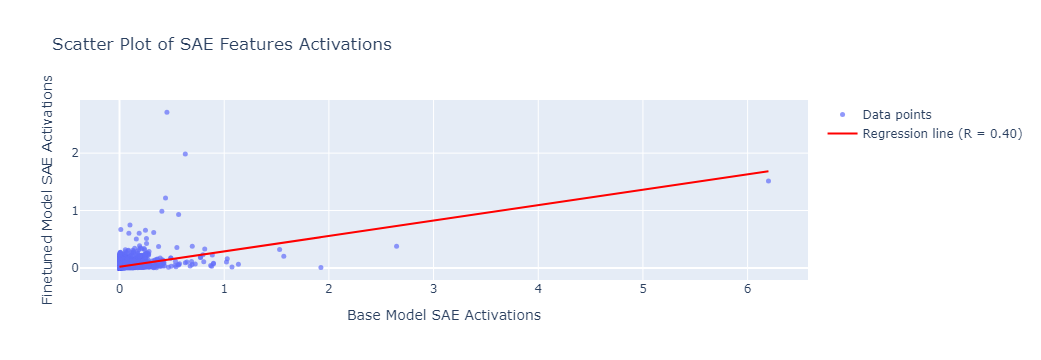

Correlation coefficient (R): 0.3970


In [10]:
import plotly.graph_objs as go
from scipy.stats import linregress

# Convert tensors to NumPy arrays for compatibility with other libraries
base_feature_acts_np = base_feature_acts.cpu().numpy()
finetune_feature_acts_np = finetune_feature_acts.cpu().numpy()

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(base_feature_acts_np, finetune_feature_acts_np)

# Define the regression line
regression_line = slope * base_feature_acts_np + intercept

# Create scatter plot
scatter_trace = go.Scatter(
    x=base_feature_acts_np,
    y=finetune_feature_acts_np,
    mode='markers',
    name='Data points',
    marker=dict(size=5, opacity=0.7)
)

# Create the regression line plot
line_trace = go.Scatter(
    x=base_feature_acts_np,
    y=regression_line,
    mode='lines',
    name=f'Regression line (R = {r_value:.2f})',
    line=dict(color='red')
)

# Set up the layout
layout = go.Layout(
    title='Scatter Plot of SAE Features Activations',
    xaxis=dict(title='Base Model SAE Activations'),
    yaxis=dict(title='Finetuned Model SAE Activations'),
    showlegend=True
)

# Combine the traces into a figure
fig = go.Figure(data=[scatter_trace, line_trace], layout=layout)

# Show the plot
fig.show()

# Print correlation coefficient
print(f"Correlation coefficient (R): {r_value:.4f}")